# Assignment Part 1 '**Classification**'

In 1st part of assignment you are requied to implement a classifier. The given links provide examples of a classification model for MNIST handwritten digits (0-9). You can refer to the provided links for guidance.
1. https://github.com/RafayKhattak/Digit-Classification-Pytorch/tree/main
2. https://github.com/jkotra/mnist-pytorch

# **Task 1**: 30 Marks

Now your task is to implement a PyTorch model for classifying 36 characters, including digits (0-9) and alphabets (A-Z), using the dataset provided in the CNN_dataset folder.

In [1]:
# Load libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.amp import autocast 
import os
from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
from torchsummary import summary
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set the device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"


In [3]:
# Define transformations for the dataset
BATCH_SIZE = 32
IMAGE_SIZE = 28
transform_t1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
])

In [4]:
# Load dataset and prepare dataloaders
class customDataset():
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.classes = []

        for class_label, class_name in enumerate(os.listdir(self.root_dir)):
            class_path = os.path.join(self.root_dir, class_name)
            self.classes.append(class_label)

            for class_file in os.listdir(class_path):
                image_path = os.path.join(class_path, class_file)
                image = Image.open(image_path).convert('RGB')

                self.images.append(image)
                self.labels.append(class_label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.transform:
            image = self.transform(image)
            
        return image, label

train_folder_path = "./CNN_lp_dataset/train"
test_folder_path = "./CNN_lp_dataset/val"

trainset_t1 = customDataset(train_folder_path, transform=transform_t1)
testset_t1 = customDataset(test_folder_path, transform=transform_t1)

trainloader_t1 = DataLoader(trainset_t1, batch_size=BATCH_SIZE, shuffle=True)
testloader_t1 = DataLoader(testset_t1, batch_size=BATCH_SIZE, shuffle=False)

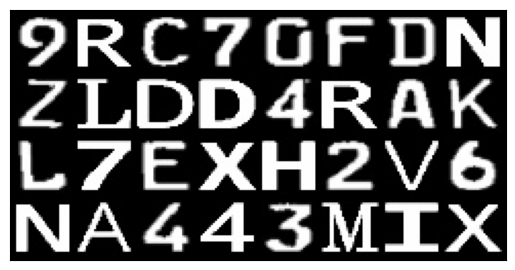

In [5]:
def visualize_dataloader(dataloader):
    data_iter = iter(dataloader)
    images, _ = next(data_iter)

    grid_images = torchvision.utils.make_grid(images)
    numpy_images = grid_images.numpy()
    numpy_images = numpy_images.transpose((1, 2, 0)).clip(0,1)
    plt.imshow(numpy_images)
    plt.xticks([])
    plt.yticks([])
    plt.show()

visualize_dataloader(trainloader_t1)

In [6]:
# Define the CNN model
class CNNNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(CNNNet, self).__init__()

        # Convolutional layers
        self.conv_l1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3)

        self.conv_l2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)

        self.conv_l3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)

        # Pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc_1 = nn.Linear(in_features=(30976), out_features=num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        # Apply convolutional layers with ReLU activation and pooling
        x = self.conv_l1(x)
        x = self.relu(x)

        x = self.conv_l2(x)
        x = self.relu(x)

        x = self.conv_l3(x)
        x = self.relu(x)

        # Dynamically flatten the output from the conv layers
        x = x.view(x.size(0), -1)

        # Fully connected layers with ReLU activation
        x = self.fc_1(x)

        # Output layer (log_softmax for classification)
        output_layer = nn.LogSoftmax(dim=1)(x)

        return output_layer

# Example model instance
in_channels = 1
num_classes = 36
model = CNNNet(in_channels=in_channels, num_classes=num_classes)
print(model)

CNNNet(
  (conv_l1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv_l2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv_l3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_1): Linear(in_features=30976, out_features=36, bias=True)
  (relu): ReLU()
)


In [7]:
# Initialize the model, loss function, and optimizer
in_channels = 1
num_classes = 36

cnn_net_model = CNNNet(in_channels=in_channels, num_classes=num_classes)
cnn_net_model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_net_model.parameters(), lr=1e-3)

In [8]:
def save_model_weights(model, path):
    if os.path.exists(path):
      torch.save(model.state_dict(), path)
    else:
      with open(path, "w") as fp:
        torch.save(model.state_dict(), path)

def get_num_params(model):
    parameters = sum(p.numel() for p in model.parameters())
    print(f"Model {parameters = }")

get_num_params(cnn_net_model)
summary(cnn_net_model, (1, 28, 28))

Model parameters = 1170916
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
              ReLU-2           [-1, 32, 26, 26]               0
            Conv2d-3           [-1, 64, 24, 24]          18,496
              ReLU-4           [-1, 64, 24, 24]               0
            Conv2d-5           [-1, 64, 22, 22]          36,928
              ReLU-6           [-1, 64, 22, 22]               0
            Linear-7                   [-1, 36]       1,115,172
Total params: 1,170,916
Trainable params: 1,170,916
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.37
Params size (MB): 4.47
Estimated Total Size (MB): 5.84
----------------------------------------------------------------


In [9]:
# Define the training function
def train(model, device, train_loader, loss_fn, optimizer, epoch, path):
    model.train()  # Set the model to training mode
    
    data = 0
    for batch_idx, (data, target) in enumerate(train_loader):

      # Move data to the correct device (GPU/CPU)
      data, target = data.to(device), target.to(device)

      # Zero the gradients
      optimizer.zero_grad()

      # Forward pass
      with autocast(device_type=device):
        outputs = model(data)
        
        # Negative log-likelihood loss
        loss = loss_fn(outputs, target)

      # Backpropagation
      loss.backward()

      # Update the weights
      optimizer.step()

      if batch_idx % 6 == 0:
        print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}'
              f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    save_model_weights(model, path)
      

In [10]:
# Define the testing function
def test(model, device, test_loader, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    test_loss = 0.0
    correct = 0
    total = len(test_loader)

    with torch.no_grad():  # Disable gradient calculation during testing
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            outputs = model(data)

            # Sum up batch loss
            loss = loss_fn(outputs, target)
            test_loss += loss.item()

            # Get the index of the max log-probability
            prediction = outputs.argmax(axis=1)

            correct += (prediction == target).sum().item()

    # Average loss
    average_loss = test_loss / total
    
    print(f'\nTest set: Average loss: {average_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')
          

In [11]:
# Training loop
path = "./cnn_net.pt"
n_epochs = 5
for epoch in range(1, n_epochs + 1):
  train(cnn_net_model, device, trainloader_t1, loss_fn, optimizer, epoch, path)
  test(cnn_net_model, device, testloader_t1, loss_fn)

Train Epoch: 1 [0/1903 (0%)]	Loss: 3.585086
Train Epoch: 1 [192/1903 (10%)]	Loss: 2.557579
Train Epoch: 1 [384/1903 (20%)]	Loss: 1.238945
Train Epoch: 1 [576/1903 (30%)]	Loss: 0.618601
Train Epoch: 1 [768/1903 (40%)]	Loss: 0.498265
Train Epoch: 1 [960/1903 (50%)]	Loss: 0.281688
Train Epoch: 1 [1152/1903 (60%)]	Loss: 0.065160
Train Epoch: 1 [1344/1903 (70%)]	Loss: 0.107291
Train Epoch: 1 [1536/1903 (80%)]	Loss: 0.071250
Train Epoch: 1 [1728/1903 (90%)]	Loss: 0.019377

Test set: Average loss: 0.1307, Accuracy: 441/458 (96%)

Train Epoch: 2 [0/1903 (0%)]	Loss: 0.012894
Train Epoch: 2 [192/1903 (10%)]	Loss: 0.087098
Train Epoch: 2 [384/1903 (20%)]	Loss: 0.068569
Train Epoch: 2 [576/1903 (30%)]	Loss: 0.030563
Train Epoch: 2 [768/1903 (40%)]	Loss: 0.059074
Train Epoch: 2 [960/1903 (50%)]	Loss: 0.058119
Train Epoch: 2 [1152/1903 (60%)]	Loss: 0.019812
Train Epoch: 2 [1344/1903 (70%)]	Loss: 0.358897
Train Epoch: 2 [1536/1903 (80%)]	Loss: 0.205218
Train Epoch: 2 [1728/1903 (90%)]	Loss: 0.017147


# **Task 2:** 20 Marks
Repeat Task 1 bit this time your model trainable parameters should less than 1 Million.

In [12]:
# Set the device (use GPU if available)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define transformations for the dataset
IMAGE_SIZE = 28
transform_t2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Grayscale(num_output_channels=1),
])

In [13]:
# Write down batch generator to load data
train_folder_path = "./CNN_lp_dataset/train"
test_folder_path = "./CNN_lp_dataset/val"

trainset_t2 = customDataset(train_folder_path, transform=transform_t2)
testset_t2 = customDataset(test_folder_path, transform=transform_t2)

trainloader_t2 = DataLoader(trainset_t2, batch_size=BATCH_SIZE, shuffle=True)
testloader_t2 = DataLoader(testset_t2, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
# Define the convolutional neural network model
class DepthwiseSeperableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DepthwiseSeperableConv, self).__init__()
        self.depthwise = nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=3, padding=0, groups=in_channels)
        self.pointwise = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
    
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class CNN_Task2(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Task2, self).__init__()
        self.layers = nn.Sequential(
            DepthwiseSeperableConv(1, 32),
            nn.ReLU(),

            DepthwiseSeperableConv(32, 64),
            nn.ReLU(),

            DepthwiseSeperableConv(64, 64),
            nn.ReLU(),

            nn.MaxPool2d(kernel_size=2, stride=2),

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=(7744), out_features=num_classes)
        )
        
    
    def forward(self, x):
        x = self.layers(x)

        x = self.classifier(x)

        output_layer = nn.LogSoftmax(dim=1)(x)

        return x

In [15]:
# Initialize the model, loss function, and optimizer
cnn_task2_model = CNN_Task2(num_classes)
cnn_task2_model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_task2_model.parameters(), lr=1e-3)

In [16]:
get_num_params(cnn_task2_model)
summary(cnn_task2_model, (1, 28, 28))

Model parameters = 286126
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 1, 26, 26]              10
            Conv2d-2           [-1, 32, 26, 26]              64
DepthwiseSeperableConv-3           [-1, 32, 26, 26]               0
              ReLU-4           [-1, 32, 26, 26]               0
            Conv2d-5           [-1, 32, 24, 24]             320
            Conv2d-6           [-1, 64, 24, 24]           2,112
DepthwiseSeperableConv-7           [-1, 64, 24, 24]               0
              ReLU-8           [-1, 64, 24, 24]               0
            Conv2d-9           [-1, 64, 22, 22]             640
           Conv2d-10           [-1, 64, 22, 22]           4,160
DepthwiseSeperableConv-11           [-1, 64, 22, 22]               0
             ReLU-12           [-1, 64, 22, 22]               0
        MaxPool2d-13           [-1, 64, 11, 11]               0


In [17]:
# Define the training function
def train(model, device, train_loader, loss_fn, optimizer, epoch):
    model.train()  # Set the model to training mode
    
    for batch_idx, (images, labels) in enumerate(train_loader):

      # Move data to the correct device (GPU/CPU)
      images, labels = images.to(device), labels.to(device)

      # Zero the gradients
      optimizer.zero_grad()

      # Forward pass
      with autocast(device_type=device):
        outputs = model(images)
        
        # Negative log-likelihood loss
        loss = loss_fn(outputs, labels)

      # Backpropagation
      loss.backward()

      # Update the weights
      optimizer.step()

      if batch_idx % 6 == 0:
        print(f'Train Epoch: {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)}'
              f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    print(f'Train Epoch: {epoch} [{batch_idx * len(images)}/{len(train_loader.dataset)}'
              f' ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

In [18]:
# Define the testing function
def test(model, device, test_loader, loss_fn):
    # Set the model to evaluation mode
    model.eval()
    test_loss = 0.0
    correct = 0
    total = len(test_loader)

    with torch.no_grad():  # Disable gradient calculation during testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            # Sum up batch loss
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()

            # Get the index of the max log-probability
            prediction = outputs.argmax(axis=1)

            correct += (prediction == labels).sum().item()

    # Average loss
    average_loss = test_loss / total

    print(f'\nTest set: Average loss: {average_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)}'
          f' ({100. * correct / len(test_loader.dataset):.0f}%)\n')


In [19]:
# Training loop
epochs = 5
for epoch in range(1, epochs + 1):
  train(cnn_task2_model, device, trainloader_t2, loss_fn, optimizer, epoch)
  test(cnn_task2_model, device, testloader_t2, loss_fn)

Train Epoch: 1 [0/1903 (0%)]	Loss: 3.580383
Train Epoch: 1 [192/1903 (10%)]	Loss: 3.462769
Train Epoch: 1 [384/1903 (20%)]	Loss: 3.485840
Train Epoch: 1 [576/1903 (30%)]	Loss: 3.443970
Train Epoch: 1 [768/1903 (40%)]	Loss: 3.410828
Train Epoch: 1 [960/1903 (50%)]	Loss: 3.541260
Train Epoch: 1 [1152/1903 (60%)]	Loss: 3.312622
Train Epoch: 1 [1344/1903 (70%)]	Loss: 3.467590
Train Epoch: 1 [1536/1903 (80%)]	Loss: 3.555176
Train Epoch: 1 [1728/1903 (90%)]	Loss: 3.554504
Train Epoch: 1 [885/1903 (98%)]	Loss: 3.327865

Test set: Average loss: 3.4036, Accuracy: 31/458 (7%)

Train Epoch: 2 [0/1903 (0%)]	Loss: 3.287048
Train Epoch: 2 [192/1903 (10%)]	Loss: 3.264404
Train Epoch: 2 [384/1903 (20%)]	Loss: 3.171265
Train Epoch: 2 [576/1903 (30%)]	Loss: 2.995941
Train Epoch: 2 [768/1903 (40%)]	Loss: 2.314194
Train Epoch: 2 [960/1903 (50%)]	Loss: 1.233049
Train Epoch: 2 [1152/1903 (60%)]	Loss: 0.466484
Train Epoch: 2 [1344/1903 (70%)]	Loss: 0.464925
Train Epoch: 2 [1536/1903 (80%)]	Loss: 0.265841
Tra

Confusion Matrix


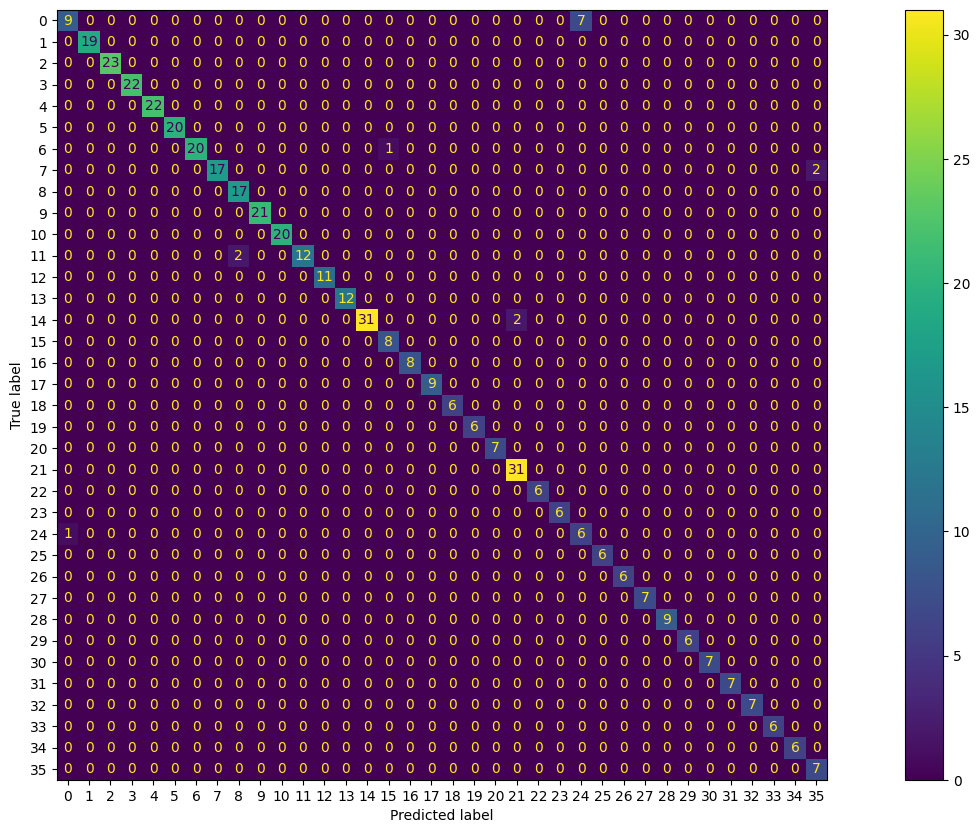

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.56      0.69        16
           1       1.00      1.00      1.00        19
           2       1.00      1.00      1.00        23
           3       1.00      1.00      1.00        22
           4       1.00      1.00      1.00        22
           5       1.00      1.00      1.00        20
           6       1.00      0.95      0.98        21
           7       1.00      0.89      0.94        19
           8       0.89      1.00      0.94        17
           9       1.00      1.00      1.00        21
          10       1.00      1.00      1.00        20
          11       1.00      0.86      0.92        14
          12       1.00      1.00      1.00        11
          13       1.00      1.00      1.00        12
          14       1.00      0.94      0.97        33
          15       0.89      1.00      0.94         8
          16       1.00      1.00      1.00         8
     

In [20]:
# show confusion matrix, calculate precision (P%), Recall (R%), and F1 Score (f1%)
def get_labels_and_predictions(model, testloader, device):
    model.eval()
    labels = []
    predictions = []
    with torch.no_grad():
        for image, label in testloader:
            image = image.to(device)
            label = label.to(device).detach().cpu().numpy()

            output = model(image)
            prediction = output.argmax(axis=1).detach().cpu().numpy()

            labels.extend(label)
            predictions.extend(prediction)
    
    return labels, predictions

classes = testloader_t2.dataset.classes
labels, predictions = get_labels_and_predictions(cnn_task2_model, testloader_t2, device)

confusion_mat = confusion_matrix(labels, predictions, labels=classes)
display_cm = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)

target_names = [str(class_label) for class_label in classes]
cls_report = classification_report(labels, predictions, target_names=target_names, zero_division=1)

print("Confusion Matrix")
fig, ax = plt.subplots(figsize=(20, 10))
display_cm.plot(ax=ax)
plt.show()

print("Classification Report")
print(cls_report)


Great job! Now you have completed 1st part of you assignment. Hurrey!








In [21]:
print(f"CNN Net:")
get_num_params(cnn_net_model)

print(f"Task 2 Model:")
get_num_params(cnn_task2_model)

CNN Net:
Model parameters = 1170916
Task 2 Model:
Model parameters = 286126
